# Библиотеки

Импортируем всё, что понадобится в решении

In [1]:
import pandas as pd
import numpy as np

import hashlib

import datetime

import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

# Разделение пользователей на группы для A/B теста

Разобьём пользователей на контрольную и тестовую группы. Для стратификации выборки и воспроизводимости результатов будем применять к `user_id` `md5` хэш из библиотеки `hashlib` с некоторой солью

In [2]:
users = pd.read_sql(
    """
SELECT * FROM public.user_data
    """,
    con="*****"
)

users.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [3]:
salt = 'AB_test_RecSys'
num_groups = 2

users['group'] = users['user_id'].apply(lambda x:(int(hashlib.md5((str(x) + salt).encode()).hexdigest(), 16)) % num_groups)

In [4]:
users.head()

,user_id,gender,age,country,city,exp_group,os,source,group
0,200,1,34,Russia,Degtyarsk,3,Android,ads,0
1,201,0,37,Russia,Abakan,0,Android,ads,0
2,202,1,17,Russia,Smolensk,4,Android,ads,1
3,203,0,18,Russia,Moscow,1,iOS,ads,0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,0


### Проверка равномерности разделения

Для начала проверим, нет ли пользователей, попавших одновременно в обе группы или не попавших вообще

In [5]:
users.groupby('user_id')['group'].nunique().sort_values()

user_id
200       1
114129    1
114130    1
114131    1
114132    1
         ..
58121     1
58122     1
58123     1
58116     1
168552    1
Name: group, Length: 163205, dtype: int64

Как видим, каждый пользователь попал в одну из групп.

Теперь посчитаем долю контрольной и тестовой группы. Мы хотим добиться разбиения примерно 50/50

In [6]:
test_part = users[users['group'] == 0]['user_id'].count() / users.shape[0]
control_part = users[users['group'] == 1]['user_id'].count() / users.shape[0]

print(f'Доля контрольной группы: {control_part}, доля тестовой: {test_part}')

Доля контрольной группы: 0.4967617413682179, доля тестовой: 0.5032382586317821


Видим, что с процентным соотношением групп всё в порядке. Теперь проверим их стратифицированность.

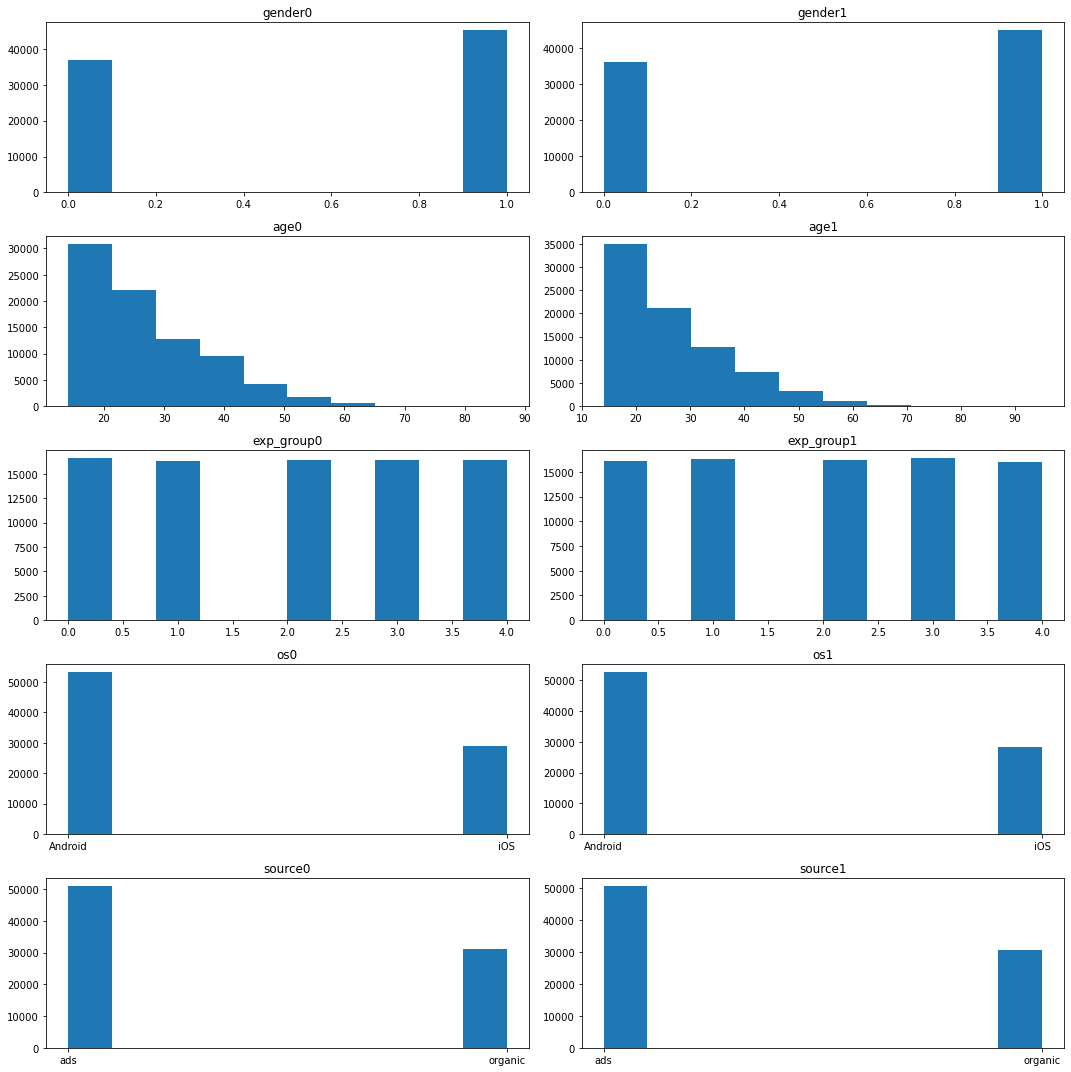

In [7]:
cols = ['gender', 'age', 'exp_group', 'os', 'source']

fig, axs = plt.subplots(len(cols), 2)
fig.set_size_inches(15, 15)

for i in range(len(cols)):
    for j in range(2):
        axs[i, j].hist(users[users['group'] == j][cols[i]])
        axs[i, j].set_title(cols[i] + str(j))
fig.tight_layout()

Получили достаточно схожие распределения по категориям для контрольной и тестовой групп.

# Обработка результатов

Представим, что мы проводили этот эксперимент на пользователях в течение 2 недель. В результаты мы получили 2 таблицы с сырыми данными:

- **Ответы сервиса с рекомендациями** — в них мы знаем, какому пользователю что мы порекомендовали и в какую группу его отнесли. И, конечно, знаем момент времени, когда это произошло.

In [8]:
path = 'C://Users/Manzzz/PROJECTS/Karpov/Stats/AB/'

views = pd.read_csv(path + 'views.csv')
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [9]:
views.shape

(193295, 4)

- **Данные о лайках** — в них мы знаем, какой пользователь и какой пост лайкнул, в том числе момент времени, когда это произошло.

In [10]:
likes = pd.read_csv(path + 'likes.csv')

likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [11]:
likes.shape

(230176, 3)

К сожалению, данные разбиты на разные таблицы, что усложняет процесс анализа. У нас есть отдельный лог того, что происходило с точки зрения рекомендаций, а действия пользователя происходят отдельно спустя некоторое время. В итоге нет универсального идентификатора, по которому можно сопоставить показанные рекомендации и лайки. Так что придётся придумывать разные подходы.

Для начала посмотрим на две метрики: **доля пользователей хотя бы с одним лайком** и **число лайков на пользователя**. Две эти метрики по смыслу похожи и скорее всего коррелируют. Ответим по нии на вопрос, стали ли пользователи в тестовой группе ставить больше лайков.

Сначала посчитаем, сколько лайков поставил каждый пользователь за время эксперимента. Эта таблица пригодится для подсчёта обеих метрик

In [12]:
likes_num = likes.groupby('user_id')['post_id'].count().reset_index(name='likes_num')

likes_num.head()

,user_id,likes_num
0,200,1
1,201,3
2,202,2
3,212,4
4,213,7


Далее отделим друг от друга лайки пользователей из контрольной и тестовой группы.

In [13]:
control_users = views[views['exp_group'] == 'control']['user_id'].unique()
test_users = views[views['exp_group'] == 'test']['user_id'].unique()

control_likes = likes_num[likes_num['user_id'].isin(control_users)]
test_likes = likes_num[likes_num['user_id'].isin(test_users)]

- **Доля пользователей с хотя бы одним лайком**

В таблицу `likes_num` попали только пользователи, поставившие хотя бы один лайк (так как в исходной таблице `likes` были только такие). Поэтому количество таких пользователей в обеих группах ловольно легко посчитать

In [14]:
N_pos_control = control_likes.shape[0]
N_pos_test = test_likes.shape[0]

Применим z-тест для долей, чтобы проверить, значимо ли различие между группами. Зафиксируем уровень значимости $\alpha=0.05$.

In [15]:
N_control = control_users.shape[0]
N_test = test_users.shape[0]

proportions_ztest(count=[N_pos_control, N_pos_test], 
                  nobs=[N_control, N_test], 
                  alternative='two-sided')

(-2.843953164563546, 0.004455759704473447)

Получили значение p-value $\approx 0.0045 < \alpha$, поэтому можем отклонить нулевую гипотезу о равенстве долей пользователей с хотя бы одним лайком в двух генеральных совокупностях

In [16]:
N_pos_control / N_control, N_pos_test / N_test

(0.8913271929282315, 0.8981722438232863)

Установили, что в тестовой группе наблюдается статистически значимое увеличение доли пользователей с хотя бы одним лайком

- **Число лайков на пользователя**

Сформируем выборки количества лайков для каждой группы

In [17]:
control_num = control_likes['likes_num'].values
test_num = test_likes['likes_num'].values

В качестве статистического критерия используем критерий Манна-Уитни-Уилкоксона

In [18]:
mannwhitneyu(control_num, test_num, alternative='two-sided')

MannwhitneyuResult(statistic=416725715.0, pvalue=0.0016864252455297607)

Получили значение p-value < $\alpha$, поэтому отвергаем нулевую гипотезу о принадлежности выборок одной генеральной совокупности

In [19]:
control_num.mean(), test_num.mean()

(3.9131007698176017, 4.000715819613458)

Видим, что среднее число лайков на пользователя больше в тестовой выборке.

В итоге, можем заключить, что обе метрики в тестовой группе статистически значимо улучшились, то есть лайкать стали больше

## Hitrate

Далее посчитаем hitrate, то есть долю рекомендаций, в которых был хотя бы один лайк. Сначала посчитаем общий hitrate без привязки к контрольной/тестовой группе, а затем уже проведём статистический тест.

Главная проблема здесь $-$ отсутствие id показа, по которому мы бы могли сделать join таблиц `likes` и `views`.

Для решения этой проблемы сначала соберём в общую таблицу все показы и лайки по каждому пользователю, а затем уже будем фильтровать, относился ли лайк к показу этих рекомендаций или нет.

При формировании общей таблицы стоит учитывать, что могли быть рекомендации без лайков, поэтому в конце нужно будет поделить на количество уникальных рекомендаций не в полученной таблице, а в исходной таблице `views`. Можно было бы учесть это с помощью left join, но полученные `NaN values` создадут проблему при работе с датой и временем. 

In [20]:
merged = pd.merge(views, likes, on='user_id')

merged.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,[3644 4529 4704 5294 4808],1654030803,4704,1654030804
1,128381,control,[3644 4529 4704 5294 4808],1654030803,5294,1654030838
2,128381,control,[3644 4529 4704 5294 4808],1654030803,3608,1655049327
3,128381,control,[3644 4529 4704 5294 4808],1654030803,2542,1655049342
4,128381,control,[3644 4529 4704 5294 4808],1654030803,4165,1655052806


Сначала проведём фильтрацию по времени. Наложим два условия:
1. Лайк не должен предшествовать показу рекомендаций
2. Лайк был совершён не сильно позже показа рекомендаций. В качестве порога отсечения возьмём 1 час

Для удобства работы со временем переведём колонки `timestamp` в формат `datetime`

In [21]:
merged['datetime'] = merged['timestamp_x'].apply(lambda x: datetime.datetime.fromtimestamp(x))
merged['datetime_likes'] = merged['timestamp_y'].apply(lambda x: datetime.datetime.fromtimestamp(x))

merged = merged.drop(['timestamp_x', 'timestamp_y'], axis=1)

merged.head()

,user_id,exp_group,recommendations,post_id,datetime,datetime_likes
0,128381,control,[3644 4529 4704 5294 4808],4704,2022-06-01 00:00:03,2022-06-01 00:00:04
1,128381,control,[3644 4529 4704 5294 4808],5294,2022-06-01 00:00:03,2022-06-01 00:00:38
2,128381,control,[3644 4529 4704 5294 4808],3608,2022-06-01 00:00:03,2022-06-12 18:55:27
3,128381,control,[3644 4529 4704 5294 4808],2542,2022-06-01 00:00:03,2022-06-12 18:55:42
4,128381,control,[3644 4529 4704 5294 4808],4165,2022-06-01 00:00:03,2022-06-12 19:53:26


Также будем следить за размерностью таблицы. В итоге должны получить что-то сопоставимое с размером исходной таблицы `views`

In [22]:
views.shape, merged.shape

((193295, 4), (1006642, 6))

Отфильтруем данные по времени лайков и показа рекомендаций

In [23]:
merged = merged[(merged['datetime_likes'] > merged['datetime']) & 
                (merged['datetime'] + datetime.timedelta(hours=1) >= merged['datetime_likes'])]

views.shape, merged.shape

((193295, 4), (232518, 6))

Уже получили сопоставимые размеры таблиц, но ещё, помимо фильтрации по времени, нужно посмотреть, был ли пост, на который поставили лайк, в наших рекомендациях. Для этого сначала переведём значения в колонке `recommendations` в списки

In [24]:
merged['recommendations'] = merged['recommendations'].apply(lambda x: x[1:-1].split())

merged.head()

,user_id,exp_group,recommendations,post_id,datetime,datetime_likes
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",4704,2022-06-01 00:00:03,2022-06-01 00:00:04
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",5294,2022-06-01 00:00:03,2022-06-01 00:00:38
16,128381,control,"[3029, 3608, 2542, 4165, 3490]",3608,2022-06-12 18:55:26,2022-06-12 18:55:27
17,128381,control,"[3029, 3608, 2542, 4165, 3490]",2542,2022-06-12 18:55:26,2022-06-12 18:55:42
18,128381,control,"[3029, 3608, 2542, 4165, 3490]",4165,2022-06-12 18:55:26,2022-06-12 19:53:26


Для того, чтобы корректно проверять, был ли пост в рекоммендациях, приведём значения в колонке `post_id` к строковому типу

In [25]:
merged['post_id'] = merged['post_id'].astype(str)

In [26]:
merged = merged[merged.apply(lambda x: x['post_id'] in x['recommendations'], axis=1)]

views.shape, merged.shape

((193295, 4), (230178, 6))

Теперь посчитаем количество лайков в каждом показе рекомендаций (не забываем, что здесь только те показы, где был хотя бы один лайк). Для того, чтобы метод `groupby` отработал, нужно привести значения в колонке `recommendations` к строковому типу

In [27]:
merged['recommendations'] = merged['recommendations'].astype(str)

final = merged.groupby(['user_id', 'exp_group', 'recommendations'])['post_id'].count().reset_index(name='num_likes')

final.head()

,user_id,exp_group,recommendations,num_likes
0,200,test,"['5559', '5510', '4127', '5135', '1563']",1
1,201,test,"['4962', '6881', '2631', '643', '6168']",2
2,201,test,"['6167', '1905', '1134', '3401', '6068']",1
3,202,test,"['727', '4873', '353', '1144', '1437']",2
4,212,test,"['1707', '1264', '6486', '7268', '4541']",1


Окончательно, посчитаем долю всех рекомендаций, где был хотя бы один лайк

In [28]:
print(f"Доля рекомендаций, где был хотя бы один лайк = {round(final.shape[0] / views['recommendations'].nunique(), 2)}")

Доля рекомендаций, где был хотя бы один лайк = 0.71


## Оценка различий hitrate между группами

Здесь мы не можем применить z-тест для долей, так как в каждой выборке один и тот же пользователь может встречаться несколько раз. Поэтому применим **бакетный подход**, то есть перейдём к группам пользователей, которые будем рассматривать в качестве метапользователей, и уже по ним оценим значимость.


Для начала на всякий случай проверим, нет ли у нас в таблице `likes` пользователей, которым мы не давали рекомендации

In [29]:
likes[~(likes['user_id'].isin(views['user_id'].unique()))]

,user_id,post_id,timestamp


Как видим, с этим всё в порядке.

Теперь для разбиения на бакеты применим к `user_id` из `views` `md5` хэш из `hashlib` с другой солью. Сделаем 100 бакетов

In [30]:
salt = '100buckets_split'

views['bucket'] = views['user_id'].apply(lambda x: int(hashlib.md5((str(x) + salt).encode()).hexdigest(), 16) % 100)

views.head()

,user_id,exp_group,recommendations,timestamp,bucket
0,128381,control,[3644 4529 4704 5294 4808],1654030803,39
1,146885,test,[1399 1076 797 7015 5942],1654030811,37
2,50948,test,[2315 3037 1861 6567 4093],1654030825,56
3,37703,test,[2842 1949 162 1588 6794],1654030826,95
4,14661,test,[2395 5881 5648 3417 673],1654030829,10


Теперь создадим для дальнейшего удобства таблицу `user_id` - бакет

In [31]:
user_bucket = views[['user_id', 'bucket']].drop_duplicates()

user_bucket.head()

,user_id,bucket
0,128381,39
1,146885,37
2,50948,56
3,37703,95
4,14661,10


Проверим, насколько равномерным получилось разделение

<AxesSubplot:>

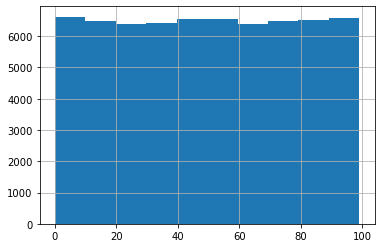

In [32]:
user_bucket['bucket'].hist()

Видим, что пользователи достаточно равномерно распределены по бакетам.

Теперь добавим к полученной на прошлом этапе таблице `final` информацию о бакетах

In [33]:
final = final.merge(user_bucket, on='user_id')

final.head()

,user_id,exp_group,recommendations,num_likes,bucket
0,200,test,"['5559', '5510', '4127', '5135', '1563']",1,59
1,201,test,"['4962', '6881', '2631', '643', '6168']",2,5
2,201,test,"['6167', '1905', '1134', '3401', '6068']",1,5
3,202,test,"['727', '4873', '353', '1144', '1437']",2,56
4,212,test,"['1707', '1264', '6486', '7268', '4541']",1,74


Чтобы посчитать бакетный hitrate, посчитаем общее количество рекомендаций и лайков в каждом бакете

In [34]:
views_num = views.groupby(['exp_group', 'bucket'])['recommendations'].count().reset_index(name='views')
views_num.head()

,exp_group,bucket,views
0,control,0,1073
1,control,1,830
2,control,2,994
3,control,3,884
4,control,4,1028


In [35]:
likes_num = final.groupby(['exp_group', 'bucket'])['num_likes'].count().reset_index(name='likes')
likes_num.head()

,exp_group,bucket,likes
0,control,0,758
1,control,1,597
2,control,2,719
3,control,3,621
4,control,4,698


Объединим эти две таблицы и посчитаем hitrate каждого бакета

In [36]:
hitrates = views_num.merge(likes_num, on=['exp_group', 'bucket'])

hitrates['hitrate'] = hitrates['likes'] / hitrates['views']

hitrates.head()

,exp_group,bucket,views,likes,hitrate
0,control,0,1073,758,0.706431
1,control,1,830,597,0.719277
2,control,2,994,719,0.723340
3,control,3,884,621,0.702489
4,control,4,1028,698,0.678988


Наконец, применим критерий Манна-Уитни-Уилкоксона к значениям бакетных hitrate в контрольной и тестовой группе. Уровень значимости оставим равным 0.05

In [37]:
mannwhitneyu(hitrates[hitrates['exp_group'] == 'control']['hitrate'], hitrates[hitrates['exp_group'] == 'test']['hitrate'])

MannwhitneyuResult(statistic=2945.0, pvalue=5.168594430854752e-07)

In [38]:
hitrates[hitrates['exp_group'] == 'control']['hitrate'].mean(), hitrates[hitrates['exp_group'] == 'test']['hitrate'].mean()

(0.7065945922448991, 0.7197440538465228)

## Вывод

Видим, что полученное значение p-value меньше заданного уровня значимости, поэтому можем говорить, что получили статистически значимое улучшение hitrate в тестовой группе